In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

#MODEL CONSTANTS AND PARAMETERS
m       =   400             #Masa ala
I_theta =   200             #Momento de Inercia
S_theta =   180             #Momento Estático
K_theta =   3E5            #Rigidez de Torsión
K_h     =   1E5             #Rigidez de Momento
e       =   0.2             #Factor de Excentricidad
c       =   6               #Cuerda
b       =   c/2             #Media cuerda
rho     =   0.53            #Densidad
U_values = [100, 200, 300,400]
S       =   122.6           #Superficie Alar
C_L_a   =   0.03029         #Coeficiente de Lift (Ángulo de Ataque)

# Definir las matrices
M = np.array([[m,S_theta],
                  [S_theta,I_theta]])
K = np.array([[K_h,0],
                [0,K_theta]])
A0 = np.array([[0,-S*C_L_a],
                [0,2*S*e*b*C_L_a]])

A1 = np.array([[-S*C_L_a,0],
                [S*e*c*C_L_a,0]])

# Condiciones iniciales
initial_conditions = [0.0, 0.01, 0.0, 0.0872665]

# Intervalo de tiempo
t_initial = 0
t_final = 5
t_span = (t_initial, t_final)

Modelo Aerodinámico Estacionario

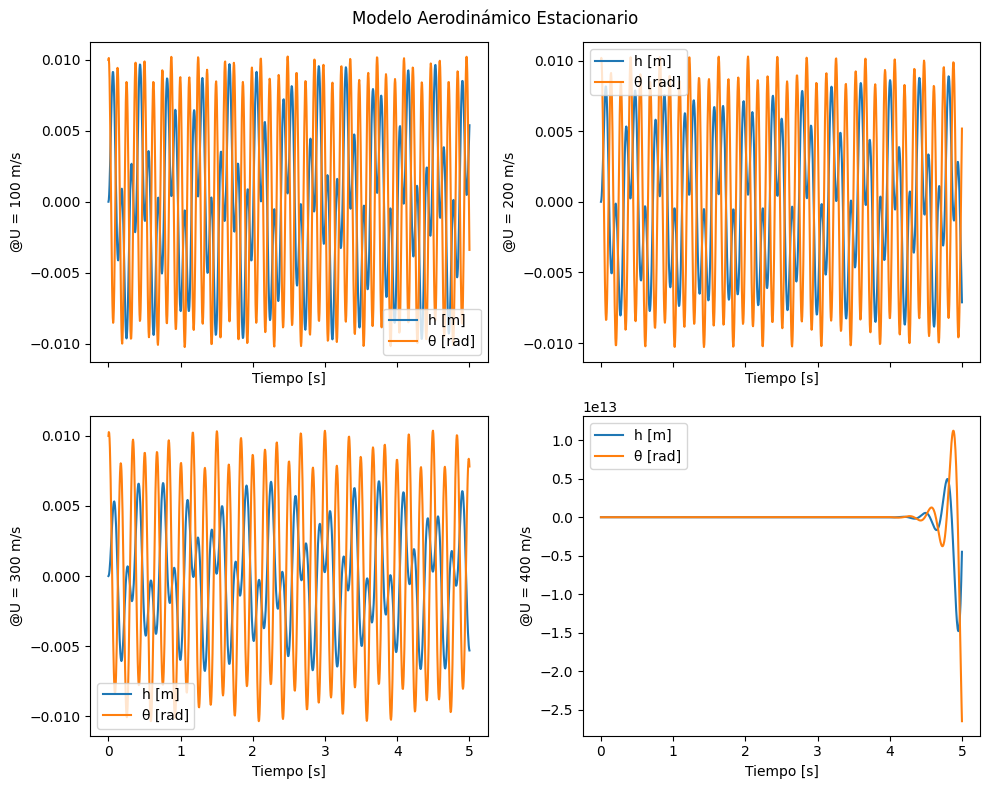

In [2]:
def system(t, y, q, U):
    dydt = np.zeros_like(y)
    dydt[:2] = y[2:]
    dydt[2:] = np.linalg.inv(M) @ ( - (K - q * A0) @ y[:2])
    return dydt

# Crear subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Graficar los resultados para cada valor de U
for i, U in enumerate(U_values):
    q = (1/2) * rho * U**2  # Actualizar la presión dinámica
    
    # Resolver el sistema de ecuaciones diferenciales
    sol = solve_ivp(system, t_span, initial_conditions, args=(q, U), method='RK45', dense_output=True)
    
    # Obtener las coordenadas de la subgráfica actual
    row, col = divmod(i, 2)
    
    # Graficar los resultados en la subgráfica correspondiente
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    y_values = sol.sol(t_values)
    
    axs[row, col].plot(t_values, y_values[0, :].T, label=f'h [m]')
    axs[row, col].plot(t_values, y_values[1, :].T, label=f'θ [rad]')
    axs[row, col].set_ylabel(f'@U = {U} m/s')
    axs[row, col].set_xlabel('Tiempo [s]')
    axs[row, col].legend()

# Etiquetas y título comunes
plt.suptitle('Modelo Aerodinámico Estacionario')
plt.tight_layout()
plt.show()

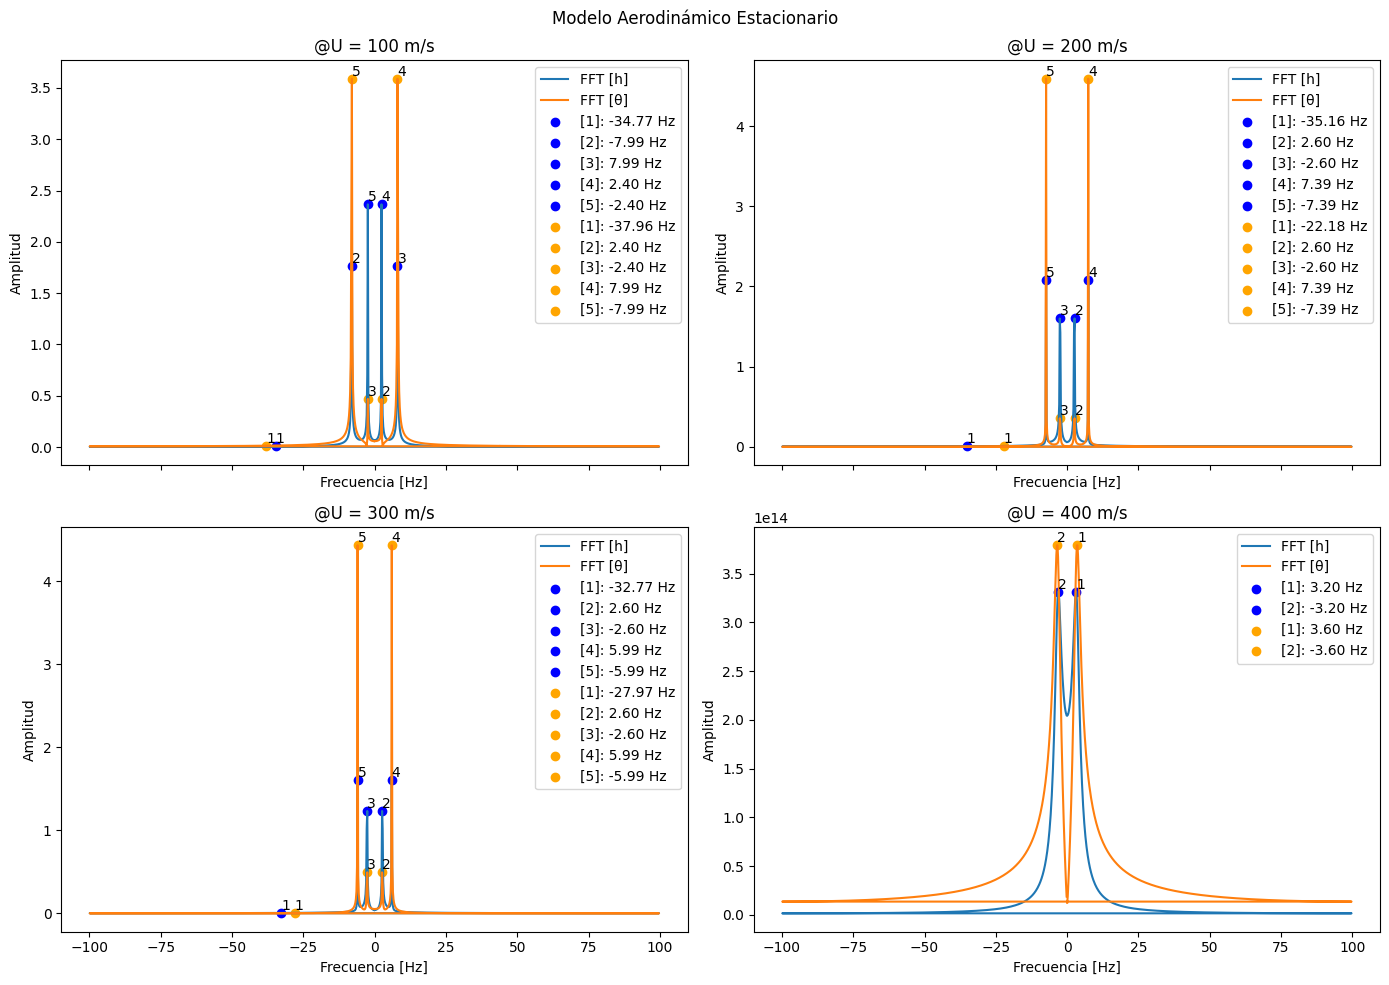

In [3]:
# Crear subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Graficar la Transformada Rápida de Fourier para h y theta para cada valor de U
for i, U in enumerate(U_values):
    q = (1/2) * rho * U**2  # Actualizar la presión dinámica
    
    # Resolver el sistema de ecuaciones diferenciales
    sol = solve_ivp(system, t_span, initial_conditions, args=(q, U), method='RK45', dense_output=True)
    
    # Obtener los valores de tiempo y las soluciones
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    y_values = sol.sol(t_values)
    
    # Calcular la Transformada Rápida de Fourier para h y theta
    fft_h = fft(y_values[0, :])
    fft_theta = fft(y_values[1, :])

    # Calcular las frecuencias correspondientes
    frequencies = fftfreq(len(t_values), t_values[1] - t_values[0])
    
    # Obtener las coordenadas de la subgráfica actual
    row, col = divmod(i, 2)
    
    # Graficar la Transformada Rápida de Fourier para h y theta
    axs[row, col].plot(frequencies, np.abs(fft_h), label=f'FFT [h]')
    axs[row, col].plot(frequencies, np.abs(fft_theta), label=f'FFT [θ]')

    # Encontrar los picos en la FFT
    peaks_h, _ = find_peaks(np.abs(fft_h), height=0)  # Se especifica height=0 para considerar todos los picos
    peaks_theta, _ = find_peaks(np.abs(fft_theta), height=0)
    
    # Seleccionar las 5 primeras frecuencias con picos más altos
    top_peaks_h = peaks_h[np.argsort(np.abs(fft_h[peaks_h]))[-5:]]
    top_peaks_theta = peaks_theta[np.argsort(np.abs(fft_theta[peaks_theta]))[-5:]]
    
    # Agregar puntos rojos en las frecuencias de los picos
    i=1
    for index in top_peaks_h:
        axs[row, col].scatter(frequencies[index], np.abs(fft_h[index]), color='blue',label=f'[{i}]: {frequencies[index]:.2f} Hz')
        axs[row, col].text(frequencies[index], np.abs(fft_h[index]), f'{i}', fontsize=10, ha='left', va='bottom')
        i+=1
    i=1
    for index in top_peaks_theta:
        axs[row, col].scatter(frequencies[index], np.abs(fft_theta[index]), color='orange',label=f'[{i}]: {frequencies[index]:.2f} Hz')
        axs[row, col].text(frequencies[index], np.abs(fft_theta[index]), f'{i}', fontsize=10, ha='left', va='bottom')
        i+=1
    

    axs[row, col].set_xlabel('Frecuencia [Hz]')
    axs[row, col].set_ylabel('Amplitud')
    axs[row, col].set_title(f'@U = {U} m/s')
    axs[row, col].legend()

# Ajustar diseño y mostrar las gráficas
plt.suptitle('Modelo Aerodinámico Estacionario')
plt.tight_layout()
plt.show()

Modelo Aerodinámico de Baja Frecuencia

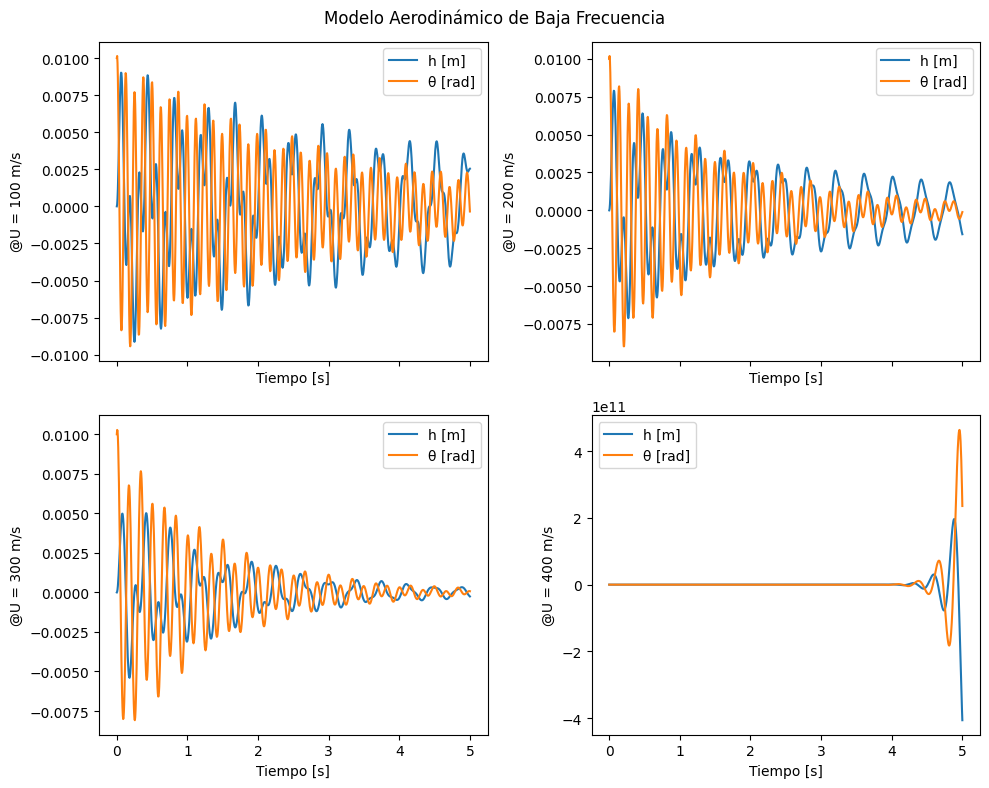

In [4]:
def system(t, y, q, U):
    dydt = np.zeros_like(y)
    dydt[:2] = y[2:]
    dydt[2:] = np.linalg.inv(M) @ ((q/U) * A1 @ y[2:] - (K - q * A0) @ y[:2])
    return dydt

# Crear subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Graficar los resultados para cada valor de U
for i, U in enumerate(U_values):
    q = (1/2) * rho * U**2  # Actualizar la presión dinámica
    
    # Resolver el sistema de ecuaciones diferenciales
    sol = solve_ivp(system, t_span, initial_conditions, args=(q, U), method='RK45', dense_output=True)
    
    # Obtener las coordenadas de la subgráfica actual
    row, col = divmod(i, 2)
    
    # Graficar los resultados en la subgráfica correspondiente
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    y_values = sol.sol(t_values)
    
    axs[row, col].plot(t_values, y_values[0, :].T, label=f'h [m]')
    axs[row, col].plot(t_values, y_values[1, :].T, label=f'θ [rad]')
    axs[row, col].set_ylabel(f'@U = {U} m/s')
    axs[row, col].set_xlabel('Tiempo [s]')
    axs[row, col].legend()

# Etiquetas y título comunes
plt.suptitle('Modelo Aerodinámico de Baja Frecuencia')
plt.tight_layout()
plt.show()

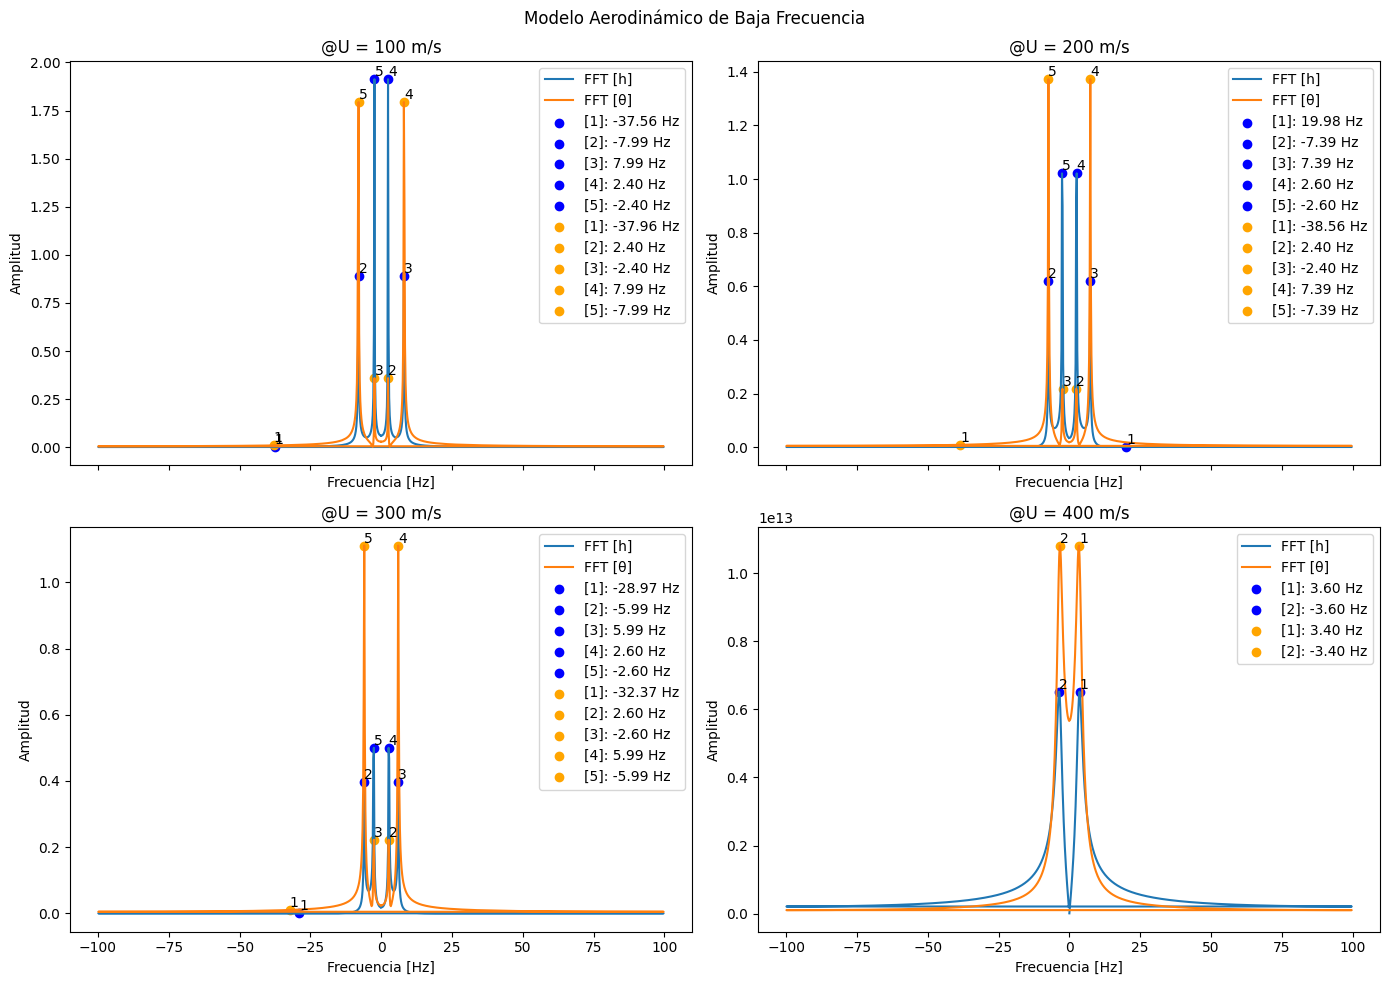

In [5]:
# Crear subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Graficar la Transformada Rápida de Fourier para h y theta para cada valor de U
for i, U in enumerate(U_values):
    q = (1/2) * rho * U**2  # Actualizar la presión dinámica
    
    # Resolver el sistema de ecuaciones diferenciales
    sol = solve_ivp(system, t_span, initial_conditions, args=(q, U), method='RK45', dense_output=True)
    
    # Obtener los valores de tiempo y las soluciones
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    y_values = sol.sol(t_values)
    
    # Calcular la Transformada Rápida de Fourier para h y theta
    fft_h = fft(y_values[0, :])
    fft_theta = fft(y_values[1, :])

    # Calcular las frecuencias correspondientes
    frequencies = fftfreq(len(t_values), t_values[1] - t_values[0])
    
    # Obtener las coordenadas de la subgráfica actual
    row, col = divmod(i, 2)
    
    # Graficar la Transformada Rápida de Fourier para h y theta
    axs[row, col].plot(frequencies, np.abs(fft_h), label=f'FFT [h]')
    axs[row, col].plot(frequencies, np.abs(fft_theta), label=f'FFT [θ]')

    # Encontrar los picos en la FFT
    peaks_h, _ = find_peaks(np.abs(fft_h), height=0)  # Se especifica height=0 para considerar todos los picos
    peaks_theta, _ = find_peaks(np.abs(fft_theta), height=0)
    
    # Seleccionar las 5 primeras frecuencias con picos más altos
    top_peaks_h = peaks_h[np.argsort(np.abs(fft_h[peaks_h]))[-5:]]
    top_peaks_theta = peaks_theta[np.argsort(np.abs(fft_theta[peaks_theta]))[-5:]]
    
    # Agregar puntos rojos en las frecuencias de los picos
    i=1
    for index in top_peaks_h:
        axs[row, col].scatter(frequencies[index], np.abs(fft_h[index]), color='blue',label=f'[{i}]: {frequencies[index]:.2f} Hz')
        axs[row, col].text(frequencies[index], np.abs(fft_h[index]), f'{i}', fontsize=10, ha='left', va='bottom')
        i+=1
    i=1
    for index in top_peaks_theta:
        axs[row, col].scatter(frequencies[index], np.abs(fft_theta[index]), color='orange',label=f'[{i}]: {frequencies[index]:.2f} Hz')
        axs[row, col].text(frequencies[index], np.abs(fft_theta[index]), f'{i}', fontsize=10, ha='left', va='bottom')
        i+=1
        
    axs[row, col].set_xlabel('Frecuencia [Hz]')
    axs[row, col].set_ylabel('Amplitud')
    axs[row, col].set_title(f'@U = {U} m/s')
    axs[row, col].legend()

# Ajustar diseño y mostrar las gráficas
plt.suptitle('Modelo Aerodinámico de Baja Frecuencia')
plt.tight_layout()
plt.show()